In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Set the path to the file you'd like to load
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "blastchar/telco-customer-churn",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

pd.set_option('display.max_columns', None)

df.head()


/tmp/ipython-input-53450764.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## ✅ Step 1: Exploratory Data Review (EDR)

In [ ]:
# Basic structure
df.shape                             # rows, columns
df.info()                            # dtypes + missing counts
df.describe()                        # numeric summary
df.describe(include="object")        # categorical summary

df.isnull().sum(axis=1)
df.nunique()


,0
0,0
1,0
2,0
3,0
4,0
...,...
7038,0
7039,0
7040,0
7041,0


## ✅ Step 2: Handling Missing Values

In [ ]:
import numpy as np
import pandas as pd
pd.Series([1.0, np.nan, 3.0])
pd.Series(["a", None, "c"])
pd.to_datetime(["2020-01-01", None, "2020-03-01"])
pd.Series([1, pd.NA, 3], dtype="Int64")   # nullable int
pd.Series([True, pd.NA, False], dtype="boolean")
s = pd.Series(["", "NA", "NULL", np.nan])
s.replace(["", "NA", "NULL"], np.nan, inplace=True)
# Check missing values
df.isnull().sum().sum()


np.int64(0)

In [ ]:
# For Telco: 'TotalCharges' often has blanks, convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Re-check missing
print(df['TotalCharges'].isnull().sum().sum())


11


In [ ]:

# Fill missing with median (numerical) or mode (categorical)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(df['TotalCharges'].isnull().sum().sum())


0


## ✅ Step 3: Correlation

In [ ]:
df.corr(numeric_only=True)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102652
tenure,0.016567,1.000000,0.247900,0.825464
MonthlyCharges,0.220173,0.247900,1.000000,0.650864
TotalCharges,0.102652,0.825464,0.650864,1.000000


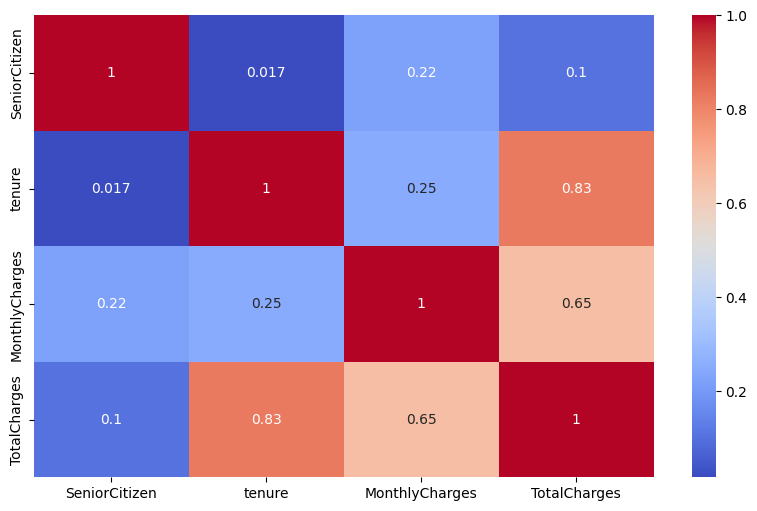

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Numeric-only correlation
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


## ✅ Step 4: Encoding Categorical Variables

#### 🔹 Label Encoding, Ordinal Encoding, One-hot Encoding (sklearn)

👉 Best for **ordinal** categories or when you want to quickly turn categories into integers.

In [ ]:
# Drop ID column (not useful for ML)
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Separate categorical & numerical
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
print("cat_cols: ", cat_cols)
print("num_cols: ", num_cols)


cat_cols:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
num_cols:  ['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

df_le = df.copy()  # keep a separate version
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_le[col] = le.fit_transform(df_le[col])
    label_encoders[col] = le  # store encoder if needed later

df_le.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

df_oe = df.copy()  # keep a separate version
ordinal_encoders = {}

for col in cat_cols:
    oe = OrdinalEncoder()
    df_oe[col] = oe.fit_transform(df_oe[col].values.reshape(-1, 1))
    ordinal_encoders[col] = oe  # store encoder if needed later

df_oe.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,0,1.0,0.0,1,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,29.85,0.0
1,1.0,0,0.0,0.0,34,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50,0.0
2,1.0,0,0.0,0.0,2,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,108.15,1.0
3,1.0,0,0.0,0.0,45,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75,0.0
4,0.0,0,0.0,0.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,151.65,1.0


In [ ]:
df_ohe = df.copy()  # keep a separate version
label_encoders = {}

ohe = OneHotEncoder(drop="first", sparse_output=False) # Set sparse_output to False
encoded = ohe.fit_transform(df_ohe[cat_cols])

encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df_ohe.index)
df_ohe = pd.concat([df_ohe.drop(columns=cat_cols), encoded_df], axis=1)

df_ohe.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,34,56.95,1889.50,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,2,53.85,108.15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,0,45,42.30,1840.75,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,70.70,151.65,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


#### 🔹 Pandas get_dummies
Quick and simple one-hot encoding built into Pandas.

In [ ]:
# One-hot encode
df_gd = df.copy()
df_gd = pd.get_dummies(df_gd, columns=cat_cols, drop_first=True)
df_gd.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges_100.2,TotalCharges_100.25,TotalCharges_100.35,TotalCharges_100.4,TotalCharges_100.8,TotalCharges_100.9,TotalCharges_1001.2,TotalCharges_1001.5,TotalCharges_1003.05,TotalCharges_1004.35,TotalCharges_1004.5,TotalCharges_1004.75,TotalCharges_1005.7,TotalCharges_1006.9,TotalCharges_1007.8,TotalCharges_1007.9,TotalCharges_1008.55,TotalCharges_1008.7,TotalCharges_1009.25,TotalCharges_101.1,TotalCharges_101.45,TotalCharges_101.65,TotalCharges_101.9,TotalCharges_1010,TotalCharges_1011.05,TotalCharges_1011.5,TotalCharges_1011.8,TotalCharges_1012.4,TotalCharges_1013.05,TotalCharges_1013.2,TotalCharges_1013.35,TotalCharges_1013.6,TotalCharges_1014.25,TotalCharges_1016.7,TotalCharges_1017.35,TotalCharges_102.45,TotalCharges_102.5,TotalCharges_102.75,TotalCharges_1020.2,TotalCharges_1020.75,TotalCharges_1021.55,TotalCharges_1021.75,TotalCharges_1021.8,TotalCharges_1022.5,TotalCharges_1022.6,TotalCharges_1022.95,TotalCharges_1023.75,TotalCharges_1023.85,TotalCharges_1023.9,TotalCharges_1023.95,TotalCharges_1024,TotalCharges_1024.65,TotalCharges_1024.7,TotalCharges_1025.05,TotalCharges_1025.15,TotalCharges_1025.95,TotalCharges_1026.35,TotalCharges_1027.25,TotalCharges_1028.75,TotalCharges_1028.9,TotalCharges_1029.35,TotalCharges_1029.75,TotalCharges_1029.8,TotalCharges_103.7,TotalCharges_1031.1,TotalCharges_1031.4,TotalCharges_1031.7,TotalCharges_1032,TotalCharges_1032.05,TotalCharges_1033,TotalCharges_1033.9,TotalCharges_1033.95,TotalCharges_1035.5,TotalCharges_1035.7,TotalCharges_1036,TotalCharges_1036.75,TotalCharges_1037.75,TotalCharges_1039.45,TotalCharges_104.2,TotalCharges_104.3,TotalCharges_1041.8,TotalCharges_1042.65,TotalCharges_1043.3,TotalCharges_1043.35,TotalCharges_1043.4,TotalCharges_1043.8,TotalCharges_1045.25,TotalCharges_1046.1,TotalCharges_1046.2,TotalCharges_1046.5,TotalCharges_1047.7,TotalCharges_1048.45,TotalCharges_1048.85,TotalCharges_1049.05,TotalCharges_1049.6,TotalCharges_105.5,TotalCharges_105.6,TotalCharges_1050.5,TotalCharges_1051.05,TotalCharges_1051.9,TotalCharges_1052.35,TotalCharges_1052.4,TotalCharges_1054.6,TotalCharges_1054.75,TotalCharges_1054.8,TotalCharges_1055.9,TotalCharges_1056.95,TotalCharges_1057,TotalCharges_1057.55,TotalCharges_1057.85,TotalCharges_1058.1,TotalCharges_1058.25,TotalCharges_1058.6,TotalCharges_1059.55,TotalCharges_106.2,TotalCharges_106.55,TotalCharges_106.8,TotalCharges_106.85,TotalCharges_106.9,TotalCharges_1060.2,TotalCharges_1060.6,TotalCharges_1061.6,TotalCharges_1062.1,TotalCharges_1064.65,TotalCharges_1064.95,TotalCharges_1066.15,TotalCharges_1066.9,TotalCharges_1067.05,TotalCharges_1067.15,TotalCharges_1067.65,TotalCharges_1068.15,TotalCharges_1068.85,TotalCharges_107.05,TotalCharges_107.1,TotalCharges_107.25,TotalCharges_107.6,TotalCharges_1070.15,TotalCharges_1070.25,TotalCharges_1070.5,TotalCharges_1070.7,TotalCharges_1071.4,TotalCharges_1071.6,TotalCharges_1072,TotalCharges_1072.6,TotalCharges_1073.3,TotalCharges_1074.3,TotalCharges_1074.65,TotalCharges_1077.05,TotalCharges_1077.5,TotalCharges_1077.95,TotalCharges_1078.75,TotalCharges_1078.9,TotalCharges_1079.05,TotalCharges_1079.45,TotalCharges_1079.65,TotalCharges_108.05,TotalCharges_108.15,TotalCharges_108.65,TotalCharges_108.7,TotalCharges_108.95,TotalCharges_1080.55,TotalCharges_1081.25,TotalCharges_1081.45,TotalCharges_1082.75,TotalCharges_1082.8

## ✅ Step 5: Feature Scaling

In [ ]:
df[num_cols]

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70
...,...,...,...
7038,0,24,84.80
7039,0,72,103.20
7040,0,11,29.60
7041,1,4,74.40


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
df_ss = df.copy()
df_mm = df.copy()
df_rs = df.copy()

scaler = StandardScaler()
df_ss[num_cols] = scaler.fit_transform(df_ss[num_cols])

scaler = MinMaxScaler()
df_mm[num_cols] = scaler.fit_transform(df_mm[num_cols])

scaler = RobustScaler()
df_rs[num_cols] = scaler.fit_transform(df_rs[num_cols])

df_ss.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,-0.439916,Yes,No,-1.277445,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,-1.160323,29.85,No
1,5575-GNVDE,Male,-0.439916,No,No,0.066327,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,-0.259629,1889.5,No
2,3668-QPYBK,Male,-0.439916,No,No,-1.236724,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-0.362660,108.15,Yes
3,7795-CFOCW,Male,-0.439916,No,No,0.514251,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.746535,1840.75,No
4,9237-HQITU,Female,-0.439916,No,No,-1.236724,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.197365,151.65,Yes


## ✅ Step 6: Outlier Handling

In [ ]:
# Example with Z-score
z_scores = np.abs((df[num_cols] - df[num_cols].mean()) / df[num_cols].std())
outliers = (z_scores > 3).any(axis=1)
print("Outliers detected:", outliers.sum())

print(df.shape)
# Option: remove
df = df[~outliers]
print(df.shape)


Outliers detected: 0
(7043, 21)
(7043, 21)


In [ ]:
# IQR method for outlier detection
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print("Outliers detected:", outliers.sum())

print(df.shape)
# Option: remove outliers
df = df[~outliers]
print(df.shape)


Outliers detected: 1142
(7043, 21)
(5901, 21)


## ✅ Step 7: Skewness Handling (Log / Power Transform)

In [ ]:
from scipy.stats import skew, kurtosis, jarque_bera, boxcox
from sklearn.preprocessing import PowerTransformer

x = df["TotalCharges"].astype(float)

# --- Metrics helper ---
def metrics(vec):
    sk = skew(vec, nan_policy='omit')
    ku = kurtosis(vec, fisher=True, nan_policy='omit')  # 0 = normal
    jb_stat, jb_p = jarque_bera(vec)
    return sk, ku, jb_p

# --- Transformations ---
x_log   = np.log1p(x)                        # log(1+x)
x_sqrt  = np.sqrt(x)                         # sqrt
x_bc, lam_bc = boxcox(x + 1e-6)              # Box-Cox needs >0
pt = PowerTransformer(method="yeo-johnson", standardize=False)
x_yj = pt.fit_transform(x.values.reshape(-1,1)).ravel()


# --- Report ---
rows = [
    ("Original", *metrics(x)),
    ("Log1p", *metrics(x_log)),
    ("Sqrt", *metrics(x_sqrt)),
    (f"Box-Cox λ={lam_bc:.3f}", *metrics(x_bc)),
    (f"Yeo–Johnson λ={pt.lambdas_[0]:.3f}", *metrics(x_yj))
]
report = pd.DataFrame(rows, columns=["Transform","Skewness","Kurtosis","JB-p"])

print(report)

# --- Plots (2×3 grid) ---
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
titles = ["Original","Log1p","Sqrt",f"Box-Cox λ={lam_bc:.3f}",f"Yeo–Johnson λ={pt.lambdas_[0]:.3f}"]
data = [x, x_log, x_sqrt, x_bc, x_yj]

for ax, d, title in zip(axes.ravel(), data, titles):
    ax.hist(d, bins=40, density=True, color="steelblue", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Fare"); ax.set_ylabel("Density")

fig.delaxes(axes[1,2])  # remove empty subplot
fig.tight_layout()
plt.show()
